# Jonathan Halverson
# Part II: Keeping it Fresh: Predict Restaurant Inspections

### This notebook examines the health inspection violation data as well as the Yelp business data. We do not work with the Yelp user reviews in this notebook (see Part III).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

### Load the training data, translation data and Yelp business data:

In [2]:
df = pd.read_csv('training_labels.txt')
df.head()

,id,date,restaurant_id,*,**,***
0,589,2010-02-02,KAoKWjog,3,0,1
1,28589,2009-12-10,p038M4om,2,0,0
2,31170,2008-07-16,B1oXymOV,4,0,0
3,2600,2015-01-30,m0oWJl3G,1,0,3
4,1016,2012-03-19,rJoQwlEV,0,0,0


In [3]:
from helper_methods import biz2yelp
trans = biz2yelp()
trans.columns = ['restaurant_id', 'business_id']
trans.head()

,restaurant_id,business_id
0,Y1Em4GOw,5Kdf1DGbRScRk6Cx3jaX8w
1,KAoKP6Og,Urw6NASrebP6tyFdjwjkwQ
2,WeEe7eoa,xlOE7jqbW1Q_PrvLBVlegQ
3,V430mqoB,ktYpqtygWIJ2RjVPGTxNaA
4,ekE4Qz32,n8CsQy7Iy1IMhP85hPVKPA


In [4]:
from helper_methods import read_json
df_biz = read_json('yelp_boston_academic_dataset_updated/yelp_academic_dataset_business.json')
df_biz.head(3)

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,"{u'Price Range': 1, u'Accepts Credit Cards': T...",Jp9svt7sRT4zwdbzQ8KQmw,"[Bakeries, Food, Event Planning & Services, Ca...",Boston,"75 Federal Street\nFinancial District\nBoston,...",{},42.355083,-71.056513,Rebecca's Cafe,[Financial District],False,6,3.5,MA,business
1,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",CgdK8DiyX9Y4kTKEPi_qgA,"[Delis, Restaurants, Event Planning & Services...",Boston,"8 City Hall Ave\nBeacon Hill\nBoston, MA 02108","{u'Tuesday': {u'close': u'15:00', u'open': u'0...",42.357500,-71.069100,Delicato Cafe & Caterer,[Beacon Hill],False,44,4.0,MA,business
2,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",SAnMTC1rm-PhP8DQC4zeyg,"[Delis, Restaurants]",Boston,"2 Center Plz\nDowntown\nBoston, MA 02108","{u'Tuesday': {u'close': u'16:00', u'open': u'0...",42.360074,-71.060187,Plaza Deli,[Downtown],True,12,3.0,MA,business


It is fun to work with the restaurant name instead of the restaurant_id so join the dataframes:

In [5]:
name_id_yelp = pd.merge(trans, df_biz, on='business_id', how='inner')
name_id_yelp.head(3)

,restaurant_id,business_id,attributes,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,Y1Em4GOw,5Kdf1DGbRScRk6Cx3jaX8w,"{u'Alcohol': u'full_bar', u'Noise Level': u'lo...","[Nightlife, Korean, Bars, Restaurants]",Allston,"90-92 Harvard Ave\nAllston/Brighton\nAllston, ...","{u'Monday': {u'close': u'01:00', u'open': u'17...",42.353256,-71.132136,Myung Dong 1st Ave,[Allston/Brighton],True,178,3.5,MA,business
1,KAoKP6Og,Urw6NASrebP6tyFdjwjkwQ,"{u'Take-out': True, u'Accepts Credit Cards': T...","[Fast Food, Sandwiches, Restaurants]",Allston,"260 Western Ave\nAllston/Brighton\nAllston, MA...","{u'Monday': {u'close': u'22:00', u'open': u'09...",42.362938,-71.133210,Subway,[Allston/Brighton],True,16,2.5,MA,business
2,WeEe7eoa,xlOE7jqbW1Q_PrvLBVlegQ,"{u'Accepts Credit Cards': False, u'Price Range...","[Food, Coffee & Tea]",Roslindale,2 Belgrade Ave\nRoslindale Village\nRoslindale...,{},42.287194,-71.129706,Emac & Bolio's,"[Roslindale Village, Roslindale]",False,6,3.5,MA,business


### Introduce weighted_violations which is an overall measure of violations

In [6]:
df['weighted_violations'] = 1 * df['*'] + 3 * df['**'] + 5 * df['***']
df.head()

,id,date,restaurant_id,*,**,***,weighted_violations
0,589,2010-02-02,KAoKWjog,3,0,1,8
1,28589,2009-12-10,p038M4om,2,0,0,2
2,31170,2008-07-16,B1oXymOV,4,0,0,4
3,2600,2015-01-30,m0oWJl3G,1,0,3,16
4,1016,2012-03-19,rJoQwlEV,0,0,0,0


Compute the average violations for each restaurant (one may also consider the mean):

In [7]:
avg_violations = df.groupby('restaurant_id').agg({'*': [np.size, np.mean, np.sum], '**': [np.mean, np.sum], '***': [np.mean, np.sum], 'weighted_violations': [np.mean, np.sum]})
avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).head(5)

weighted_violations         *                       ***      \
                             mean  sum size       mean  sum      mean sum   
restaurant_id                                                               
N6OkRvox                50.000000  100    2  19.000000   38  5.000000  10   
ZBEnAqOY                39.000000  156    4   8.000000   32  5.000000  20   
VpoGe9Er                38.000000   38    1   7.000000    7  5.000000   5   
NbE1xaOJ                28.153846  732   26  11.461538  298  2.807692  73   
WwOapwoB                28.000000   28    1  18.000000   18  2.000000   2   

                     **      
                   mean sum  
restaurant_id                
N6OkRvox       2.000000   4  
ZBEnAqOY       2.000000   8  
VpoGe9Er       2.000000   2  
NbE1xaOJ       0.884615  23  
WwOapwoB       0.000000   0

In [8]:
biz_violations = pd.merge(name_id_yelp, avg_violations, left_on='restaurant_id', right_index=True, how='inner')
biz_violations.columns = biz_violations.columns[:16].tolist() + map(lambda x: '_'.join([x[0], x[1]]), biz_violations.columns[16:])
biz_violations[['name', 'stars', 'review_count', 'weighted_violations_mean', '*_size', '*_mean', '**_mean','***_mean']].head()

,name,stars,review_count,weighted_violations_mean,*_size,*_mean,**_mean,***_mean
0,Myung Dong 1st Ave,3.5,178,1.0,1,1.000000,0.000000,0.000000
1,Subway,2.5,16,7.0,6,3.666667,0.000000,0.666667
2,Emac & Bolio's,3.5,6,2.0,2,2.000000,0.000000,0.000000
3,Pic a Pasta,3.5,66,7.5,4,2.500000,0.000000,1.000000
4,North of the Border Mexican Grill,4.5,25,10.2,15,3.133333,0.133333,1.333333


Below we list the top 25 restaurants with the highest mean weighted violations:

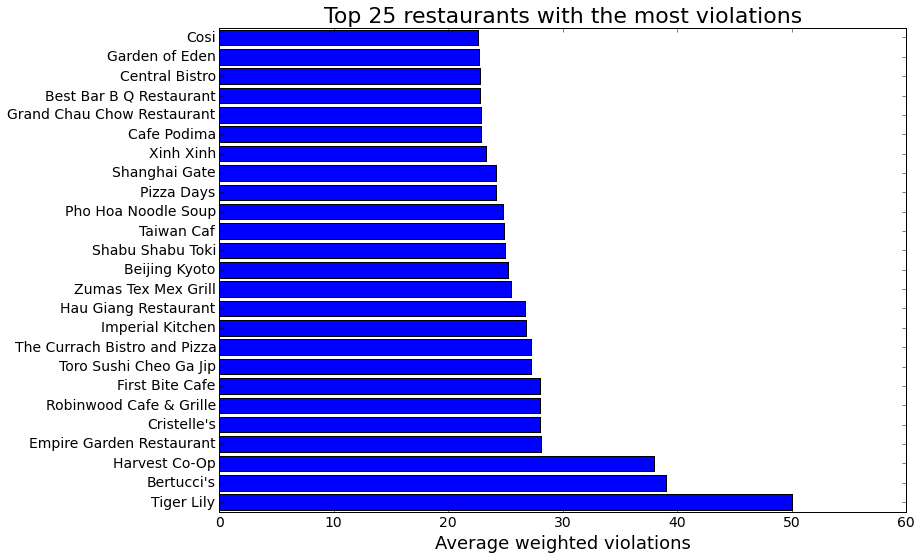

In [9]:
worst25 = biz_violations.sort_values(['weighted_violations_mean'], ascending=False).head(25)
labels = map(lambda x: x.encode('ascii', 'ignore'), worst25.name)

fig, ax = plt.subplots(1, 1, figsize=(13, 8))
plt.barh(range(25), worst25['weighted_violations_mean'], align='center')
plt.xlim(0, 60)
plt.ylim(-0.5, 24.5)
plt.yticks(range(25), labels)
plt.title('Top 25 restaurants with the most violations')
plt.xlabel('Average weighted violations')
plt.tight_layout()

### Let's look for correlations between business properties and the number of violations

(0, 30)

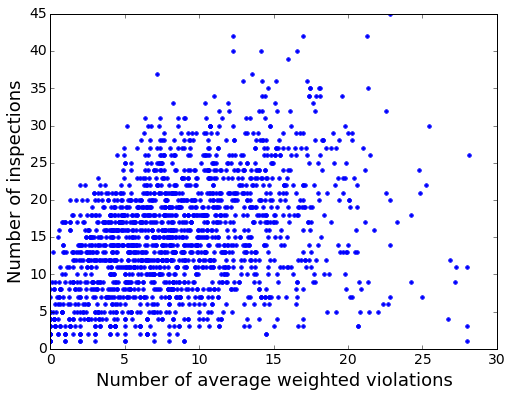

In [10]:
plt.plot(biz_violations['weighted_violations_mean'], biz_violations['*_size'], '.')
plt.xlabel('Number of average weighted violations')
plt.ylabel('Number of inspections')
plt.xlim(0, 30)

In [11]:
from scipy.stats import pearsonr
pearsonr(biz_violations['weighted_violations_mean'], biz_violations['*_size'])

(0.40024089761841369, 7.8666490556862382e-74)

We see that there is a correlation between number of inspections and mean weighted violations. This suggests that inspectors are returning to the restaurants with the worst hygiene.

### How does the restaurant star ratings vary with average number of violations?

(0, 6)

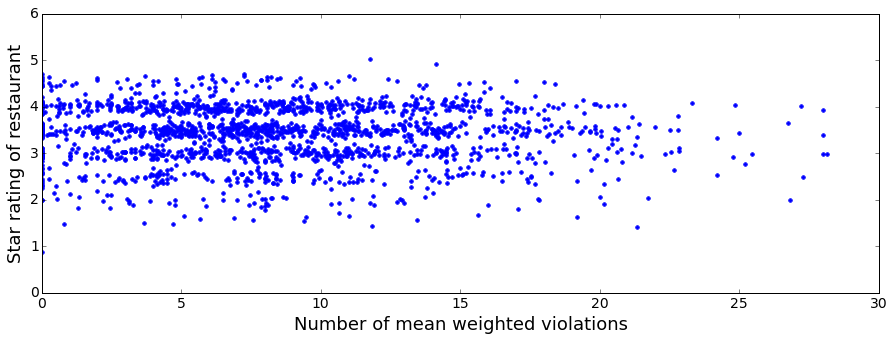

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
star_values = [star + np.random.normal(loc=0.0, scale=0.1) for star in biz_violations.stars]
plt.plot(biz_violations['weighted_violations_mean'], star_values, '.')
plt.xlabel('Number of mean weighted violations')
plt.ylabel('Star rating of restaurant')
plt.xlim(0, 30)
plt.ylim(0, 6)

In [13]:
pearsonr(biz_violations['weighted_violations_mean'], biz_violations.stars)

(-0.054315852927365488, 0.018047539034933544)

It is surprising that the star rating of the restaurant does not correlate with the mean number of violations. One would think that restaurants with lots of violations would get a low star rating while those with few would have a high rating. This is not borne out in the data.

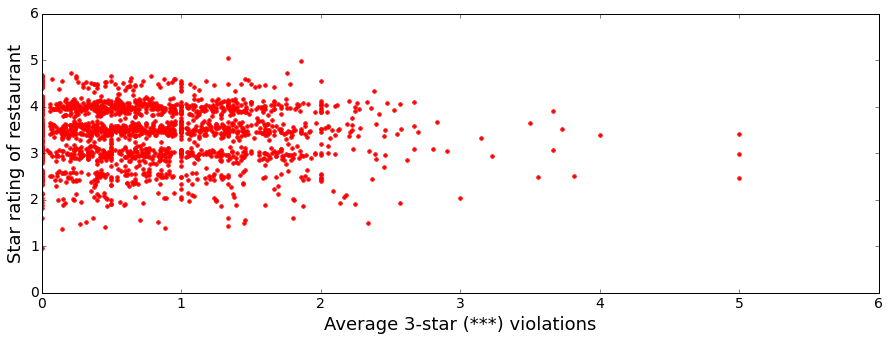

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
star_values = [star + np.random.normal(loc=0.0, scale=0.1) for star in biz_violations.stars]
plt.plot(biz_violations['***_mean'], star_values, '.', color='r')
plt.xlabel('Average 3-star (***) violations')
plt.ylabel('Star rating of restaurant')
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.title('')

In [15]:
pearsonr(biz_violations['***_mean'], biz_violations.stars)

(-0.04161892980584548, 0.070090114587617949)

### How does the review count vary with violations?

One may suspect that very good and very bad restaurants are the most written about. Again, here it would be nice to normalize by number of patrons per day or size of the restaurant. We do not have this data.

(0, 1500)

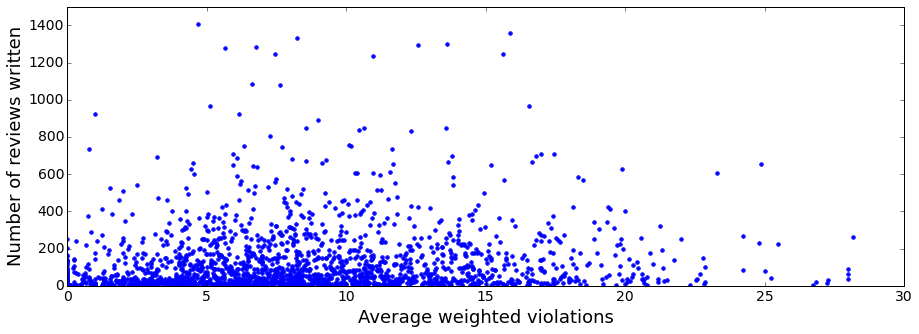

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(biz_violations['weighted_violations_mean'], biz_violations.review_count, '.')
plt.xlabel('Average weighted violations')
plt.ylabel('Number of reviews written')
plt.xlim(0, 30)
plt.ylim(0, 1500)

In [17]:
pearsonr(biz_violations['weighted_violations_mean'], biz_violations.review_count)

(0.073700315967080349, 0.0013248472164718987)

(0, 1500)

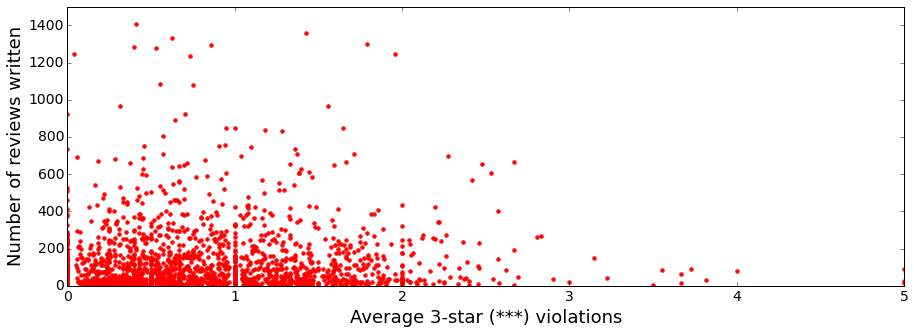

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(biz_violations[('***_mean')], biz_violations.review_count, '.', color='r')
plt.xlabel('Average 3-star (***) violations')
plt.ylabel('Number of reviews written')
plt.xlim(0, 5)
plt.ylim(0, 1500)

In [19]:
pearsonr(biz_violations[('***_mean')], biz_violations.review_count)

(0.047827888756540024, 0.03735690090593078)

### Locations

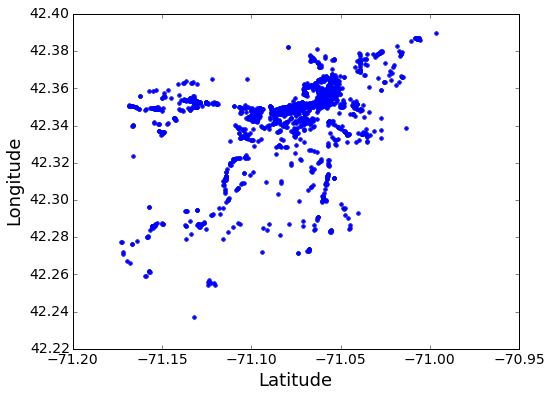

In [20]:
plt.plot(biz_violations.longitude, biz_violations.latitude, '.')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

### Conclusions

As stated above, the business data do not give significant insight into predicting health inspection violations. It's time to create a model based on the user reviews and we do that in Part 3.